# Training an Azure AutoML model with Explanations
We are using credit risk modelling dataset from Kaggle for the task. In this project, we train an AutoML model using Azure AutoML and after selecting the model,
 we assess it's fairness and interpretablity.

#### Install Required Packages

In [ ]:
!pip install azureml-explain-model azureml-interpret azureml-sdk

#### Get Data

In [1]:
from azureml.core import Workspace, Datastore, Dataset

# Get Workspace
ws = Workspace.from_config()

# Datastore Params
datastore_name = 'rohands'
storage_account_name = 'rohansa'
container_name ='rohan-blob'
# account_key = Add your account key for storage account

# Get Datastore otherwise create new datastore and register blob storage
if datastore_name in ws.datastores:
    blob_ds = Datastore.get(ws, datastore_name=datastore_name)
else:
    try:
        blob_ds = Datastore.register_azure_blob_container(
            workspace=ws,
            datastore_name=datastore_name,
            account_name=storage_account_name,
            #account_key = account_key
            container_name=container_name
        )
    except Exception as ex:
        print(ex)

# Set as Default Datastore
default_ds = ws.set_default_datastore(datastore_name)
default_ds = ws.get_default_datastore()

# Get Dataset otherise create new dataset and register
dataset_name = 'credit risk dataset'

if dataset_name not in ws.datasets:
    default_ds.upload_files(
        files=['./data/credit_risk_dataset.csv'],
        target_path='credit-risk-data/',
        overwrite=True,
        show_progress=True)
    
    tab_dataset = Dataset.Tabular.from_delimited_files(
        path=(default_ds,'credit-risk-data/*.csv'))
        
    try:
        tab_dataset = tab_dataset.register(workspace=ws, 
                                name=dataset_name,
                                description='credit risk data from Kaggle',
                                tags = {'format':'CSV'},
                                create_new_version=True)
        print('Dataset registered.')
    except Exception as ex:
        print(ex)
else:
    tab_dataset = Dataset.get_by_name(ws, dataset_name)
    print('Dataset already registered.')

train_ds, test_ds = tab_dataset.random_split(percentage=0.7, seed=999)

Dataset already registered.


##### Compute Target

In [2]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Compute params
compute_name = 'rohan-vm-cluster'
training_cluster = None

if compute_name in ws.compute_targets:
    training_cluster = ComputeTarget(ws, compute_name)
    print("Using existing cluster.")
else:
    try:
        compute_config = AmlCompute.provisioning_configuration(
            vm_size ='STANDARD_DS11_V2', 
            max_nodes=2 )
        training_cluster = ComputeTarget.create(ws, compute_name, compute_config)
        training_cluster.wait_for_completion(show_output=True)
    except Exception as ex:
        print(ex)
    print("Cluster created.")

Using existing cluster.


#### Configure and Run AML

In [12]:
from azureml.train.automl import AutoMLConfig
from azureml.core.experiment import Experiment
from azureml.widgets import RunDetails

# Configuration
automl_config = AutoMLConfig(name='Automated Credit Risk Modelling',
                             task='classification',
                             compute_target=training_cluster,
                             training_data = train_ds,
                             validation_data = test_ds,
                             label_column_name='loan_status',
                             iterations=6,
                             primary_metric = 'AUC_weighted',
                             max_concurrent_iterations=2,
                             featurization='auto'
                             )


# Run the Experiment
automl_experiment = Experiment(ws, 'azure-automl-fair-interpret-model')
automl_run = automl_experiment.submit(automl_config)
RunDetails(automl_run).show()
automl_run.wait_for_completion(show_output=True)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
azure-automl-fair-interpret-model,AutoML_929a79e2-031a-4f39-93e0-2bd14384ba50,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

Experiment,Id,Type,Status,Details Page,Docs Page
azure-automl-fair-interpret-model,AutoML_929a79e2-031a-4f39-93e0-2bd14384ba50,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation



Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       DONE
DESCRIPTION:  If the missing values are expected, let the run complete. Otherwise cancel the current run and use a script to customize the handling of missing feature values that may be more appropriate based on the data type and business 

{'runId': 'AutoML_929a79e2-031a-4f39-93e0-2bd14384ba50',
 'target': 'rohan-vm-cluster',
 'status': 'Completed',
 'startTimeUtc': '2021-07-07T04:16:24.028287Z',
 'endTimeUtc': '2021-07-07T04:27:30.25266Z',
 'properties': {'num_iterations': '6',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'AUC_weighted',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'rohan-vm-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"Automated Credit Risk Modelling","subscription_id":"23416925-66df-470c-b651-f378856d8ad7","resource_group":"rohan-rg","workspace_name":"rohan-ws","region":"centralindia","compute_target":"rohan-vm-cluster","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":false,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":false,"iterations":6,"primary_metric":"AUC_weighte

####  Get Best Run

In [59]:
best_run, fitted_model = automl_run.get_output()
print(best_run)

print('\nBest Model Definition:')
print(fitted_model)

print('\nBest Run Transformations:')
for step in fitted_model.named_steps:
    print(step)
    
print('\nBest Run Metrics:')
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print(metric_name, metric)

Package:azureml-automl-runtime, training version:1.31.0, current version:1.30.0
Package:azureml-dataprep, training version:2.18.0, current version:2.15.1
Package:azureml-dataprep-native, training version:36.0.0, current version:33.0.0
Package:azureml-dataprep-rslex, training version:1.16.0, current version:1.13.0
Package:azureml-dataset-runtime, training version:1.31.0, current version:1.30.0
Package:azureml-defaults, training version:1.31.0, current version:1.30.0
Package:azureml-mlflow, training version:1.31.0, current version:1.30.0
Package:azureml-pipeline-core, training version:1.31.0, current version:1.30.0
Package:azureml-telemetry, training version:1.31.0, current version:1.30.0
Package:azureml-train-automl-client, training version:1.31.0, current version:1.30.0
Package:azureml-train-automl-runtime, training version:1.31.0, current version:1.30.0


Run(Experiment: azure-automl-fair-interpret-model,
Id: AutoML_929a79e2-031a-4f39-93e0-2bd14384ba50_0,
Type: azureml.scriptrun,
Status: Completed)

Best Model Definition:
Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=False, enable_feature_sweeping=True, feature_sweeping_config={}, feature_sweeping_timeout=86400, featurization_config=None, force_text_dnn=False, is_cross_validation=False, is_onnx_compatible=False, observer=None, task='classification', working_dir='/mnt/batch/tasks/shared/LS_root/moun...
    subsampling_schedule='hyperband_clip',
    cost_mode_param=None,
    iteration_timeout_mode=0,
    iteration_timeout_param=None,
    feature_column_names=None,
    label_column_name=None,
    weight_column_name=None,
    cv_split_column_names=None,
    enable_streaming=None,
    timeseries_param_dict=None,
    gpu_training_param_dict={'processing_unit_type': 'cpu'}
), random_state=None))],
         verbose=False)

Best Run Transfo

#### Explain Model using PFI Explainer and Get Global Feature Importance Values

11it [00:04,  2.27it/s]


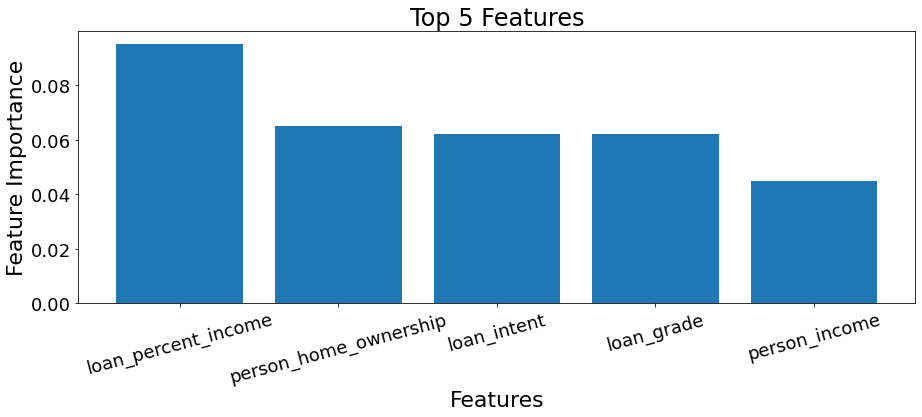

In [58]:
from interpret.ext.blackbox import PFIExplainer
import matplotlib.pyplot as plt

df = tab_dataset.to_pandas_dataframe()
features = list(df.columns).remove('loan_status')
classes = df.loan_status.unique()

X_train = train_ds.to_pandas_dataframe().drop('loan_status', axis=1)
y_train = train_ds.to_pandas_dataframe().loan_status

X_test = test_ds.to_pandas_dataframe().drop('loan_status', axis=1)
y_test = test_ds.to_pandas_dataframe().loan_status

pfi_explainer = PFIExplainer(model=fitted_model,
 features=features,
 classes=classes)

# PFIExplainer
global_explanation = pfi_explainer.explain_global(X_train, y_train)
global_feature_importance = global_explanation.get_feature_importance_dict()

# Figure
fig = plt.figure(figsize=(15,5))
top_n = 5 #len(global_feature_importance)
plt.bar(range(top_n), list(global_feature_importance.values())[:top_n], align='center')
plt.xticks(range(top_n), list(global_feature_importance.keys())[:top_n], rotation=15)
plt.tick_params(labelsize=18)

plt.title("Top {} Features".format(top_n), fontsize=24)
plt.xlabel("Features", fontsize=22)
plt.ylabel("Feature Importance", fontsize=22)
plt.show()

#### Register the Model

In [60]:
# Register model
best_run.register_model(model_path='outputs/model.pkl', model_name='credit_risk_model',
    tags={'Training context':'Auto ML Credit Risk Model'},
    properties={'AUC': best_run_metrics['AUC_weighted'], 'Accuracy': best_run_metrics['accuracy']})

Model(workspace=Workspace.create(name='rohan-ws', subscription_id='23416925-66df-470c-b651-f378856d8ad7', resource_group='rohan-rg'), name=credit_risk_model, id=credit_risk_model:1, version=1, tags={'Training context': 'Auto ML Credit Risk Model'}, properties={'AUC': '0.948567998793658', 'Accuracy': '0.937814780552986'})